https://earthquake.usgs.gov/earthquakes/search/

In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

from parser.app import ClickHouseParser, CsvParser
from parser.db import client
from parser.repo import handler
from parser.repo.driver import create_tables, drop_tables

In [18]:
datetime.now()

datetime.datetime(2023, 6, 29, 13, 49, 10, 152742)

In [16]:
year = 1990

start = datetime(year,3,6)
end = datetime(year,6,15)

parser = CsvParser(start, end, 'world', 'World_2000-2023')
parser.to_csv()

start (datetime.datetime(1990, 3, 6, 0, 0), datetime.datetime(1990, 6, 15, 0, 0)) period, with area world
1990-03-06 00:00:00 params=RequestParam(format='geojson', starttime='2023-06-18', endtime='2023-06-20', minlatitude='0.0', maxlatitude='89.0', minlongitude='0.0', maxlongitude='350.0', minmagnitude='2.5') timeout=10.0 endpoint='https://earthquake.usgs.gov/fdsnws/event/1/query' {'minlatitude': '0.0', 'maxlatitude': '89.0', 'minlongitude': '0.0', 'maxlongitude': '350.0'}


True

# Работа с таблицами

In [3]:
create_tables()

In [2]:
drop_tables()

In [5]:
result = handler.show_tables()
print(result)

ip_geo
quakes


# Загрузка данных в БД

In [4]:
start = datetime(2023,3,6)
end = datetime(2023,6,15)

parser = ClickHouseParser(start, end, 'russia')

start (datetime.datetime(2023, 3, 6, 0, 0), datetime.datetime(2023, 6, 15, 0, 0)) period, with area russia
2023-03-06 00:00:00 params=RequestParam(format='geojson', starttime='2023-06-18', endtime='2023-06-20', minlatitude='41.162', maxlatitude='81.957', minlongitude='19.688', maxlongitude='190.547', minmagnitude='2.5') timeout=10.0 endpoint='https://earthquake.usgs.gov/fdsnws/event/1/query' {'minlatitude': '41.162', 'maxlatitude': '81.957', 'minlongitude': '19.688', 'maxlongitude': '190.547'}


In [5]:
parser.upload_to_bd()

None


# Извлечение и анализ данных

In [30]:
tmp_df = client.query_df('SELECT * FROM quakes ORDER BY Date')

In [31]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype        
---  ------                  --------------  -----        
 0   Magnitude               965 non-null    float64      
 1   Longitude               965 non-null    string       
 2   Latitude                965 non-null    string       
 3   Date                    965 non-null    datetime64[s]
 4   Mercury_earth_distance  965 non-null    float64      
 5   Mercury_sun_distance    965 non-null    float64      
 6   Mercury_hlat            965 non-null    float64      
 7   Mercury_hlon            965 non-null    float64      
 8   Mercury_size            965 non-null    float64      
 9   Mercury_radius          965 non-null    float64      
 10  Mercury_a_ra            965 non-null    float64      
 11  Mercury_elong           965 non-null    float64      
 12  Venus_earth_distance    965 non-null    float64      
 13  Venus

In [10]:
spectr = tmp_df.columns.to_list()[4:]

In [11]:
magnitude = tmp_df['Mercury_sun_distance'].values.tolist()
dates = tmp_df['Date'].values.tolist()

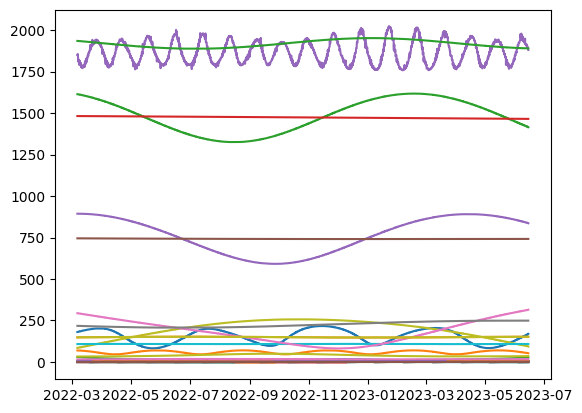

In [12]:
dates = tmp_df['Date'].values.tolist()
for col in spectr:
    plt.plot(dates, tmp_df[col].values.tolist())
plt.show()

In [13]:
tmp_query = client.query_df("""
SELECT toDate(Date), count(toDate(Date)), max(Magnitude), min(Magnitude), divide(avg(Mercury_earth_distance), 30)
FROM quakes
GROUP BY toDate(Date)
ORDER BY toDate(Date)
""")

In [10]:
tmp_query = client.query_df("""
SELECT max(Date) as last
FROM quakes
""")

In [11]:
last_datetime = tmp_query['last'].values[0].astype('M8[ms]').astype('O')
next_datetime = last_datetime + timedelta(0,1)
last_datetime, next_datetime

(datetime.datetime(2023, 6, 29, 6, 47, 2),
 datetime.datetime(2023, 6, 29, 6, 47, 3))

In [9]:
parser.update_bd()

start (datetime.datetime(2023, 6, 15, 2, 20, 18), datetime.datetime(2023, 6, 29, 14, 23, 0, 293350)) period, with area russia
2023-06-15 02:20:18 params=RequestParam(format='geojson', starttime='2023-06-18', endtime='2023-06-20', minlatitude='41.162', maxlatitude='81.957', minlongitude='19.688', maxlongitude='190.547', minmagnitude='2.5') timeout=10.0 endpoint='https://earthquake.usgs.gov/fdsnws/event/1/query' {'minlatitude': '41.162', 'maxlatitude': '81.957', 'minlongitude': '19.688', 'maxlongitude': '190.547'}
None


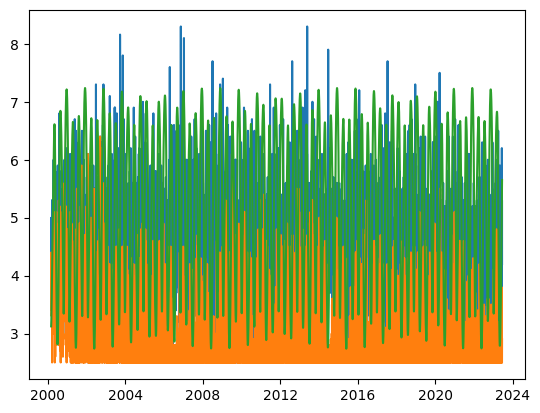

In [15]:
max_mag = tmp_query['max(Magnitude)'].values.tolist()
min_mag = tmp_query['min(Magnitude)'].values.tolist()
merc =  tmp_query['divide(avg(Mercury_earth_distance), 30)'].values.tolist()
dates = tmp_query['toDate(Date)'].values.tolist()


plt.plot(dates, max_mag)
plt.plot(dates, min_mag)
plt.plot(dates, merc)
plt.show()